In [1]:
import re
import unicodedata
import pandas as pd
import nltk

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [3]:
def show_counts_and_ratios(df, column):
    """
    This fucntion takes in a df and column name.
    Will produce a valuecounts for each label and the percetage of the data it represents
    """
    labels = pd.concat([df.label.value_counts(),
                        df.label.value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    
    return labels

show_counts_and_ratios(df, 'label')

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [4]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [5]:
all_words[0:100]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat',
 'ok',
 'lar',
 'joking',
 'wif',
 'oni',
 'free',
 'entry',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s',
 'dun',
 'say',
 'early',
 'hor',
 'c',
 'already',
 'say',
 'nah',
 'dont',
 'think',
 'go',
 'usf',
 'life',
 'around',
 'though',
 'freemsg',
 'hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'id',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'send',
 'a150',
 'rcv',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aid',
 'patent',
 'per',
 'request',
 'melle',
 'melle',
 'oru',
 'minnaminunginte',
 'nurungu',
 'vettam',
 'set',
 'callertune',
 'caller',
 'press',
 '9',
 'copy',
 'friend']

In [6]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [7]:
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

In [8]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.tail()

,all,ham,spam
zoe,2,1,1
zogtorius,1,1,0
zoom,1,1,0
zouk,1,0,1
zyada,1,1,0


In [9]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [10]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


# Visualization

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

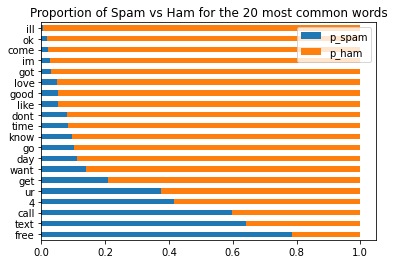

In [12]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [13]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


(-0.5, 399.5, 199.5, -0.5)

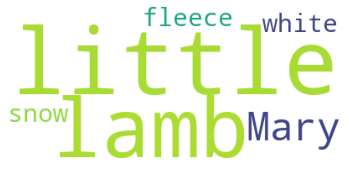

In [14]:
from wordcloud import WordCloud

sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

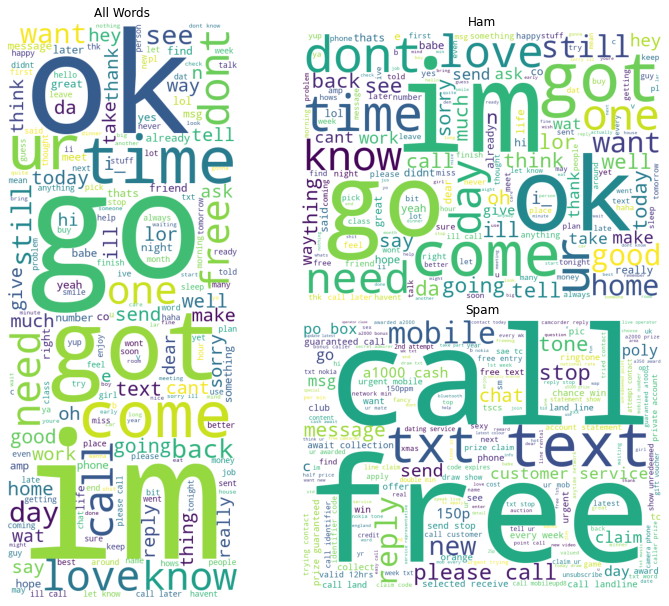

In [15]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

# Bigrams

In [16]:
sentence = 'Mary had a little lamb'

bigrams = nltk.ngrams(sentence.split(), 2)
list(bigrams)

[('Mary', 'had'), ('had', 'a'), ('a', 'little'), ('little', 'lamb')]

In [17]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

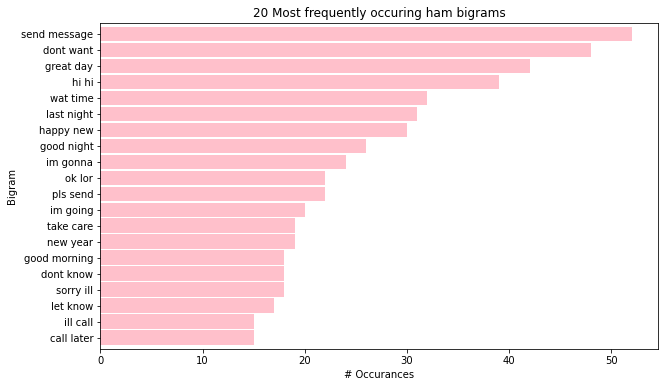

In [18]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [19]:
def show_frequent_ngram(list_of_strings, n):
    
    top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                          .value_counts()
                          .head(20))

    top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

    plt.title('20 Most frequently occuring ham bigrams')
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    
    plt.show()

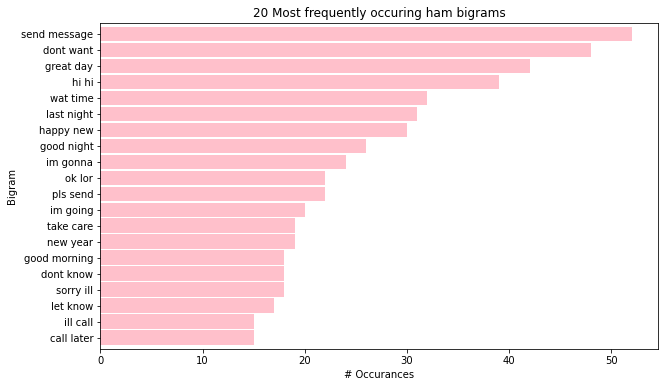

In [20]:
show_frequent_ngram(spam_words, 3)